## Variant 1 (Fear Greed)

In [37]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

Stock data for each ticker is first retrieved for the 10-year date range. This is downloaded via Yahoo Finance (Python library: yfinance).

Tickers (also known as 'symbols') are used as an identifier for a given stock. A breakdown of ticker and it's respective stock is as follows:

<li>'TSLA' == Tesla
<li>'NVDA' == Nvdia
<li>'AMZN' == Amazon
<li>'META' == Meta
<li>'RIVN' == Rivian Automotive Inc??
<li>'INTC' == Intel Corp
<li>'AMD' == Advanced Micro-Devices<br>

Closing prices ('Adj Close') and logarithmic returns are then calculated. The 10 most recent closing prices for each ticker are printed using tail(10).

In [38]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
closing_prices = data["Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    """
    Retrieves market prices and market capitalisations for a list of stock tickers. 
    Market prices are retrieved from the Vanguard S&P 500 index (VOO) based on the 
    Adjusted Close column, and market capitalisations are retrieved for each stock.

    Parameters:
    tickers: list of str
        List of stock tickers to retrieve market caps for.
    start_date: str in date format
        Start date for period to retrieve market prices.
    end_date: str in date format
        End date for period to retrieve market prices.

    Returns:
    market_prices: pd.Series
        Pandas Series of market prices for the VOO index.
    market_caps: dict
        Dictionary of tickers (keys) and market capitalisation (values). If a market cap 
        cannot be retrieved, set the value to 'None'.
    """

    market_prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)

    # Due to yFinance version 0.2.54, the data returns a Dataframe of Dataframes, instead of a Dataframe of Series
    # Hence, the 'close' column is extracted from the inner Dataframe now
    market_prices = market_prices["Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

closing_prices.tail(10)

[*********************100%***********************]  7 of 7 completed


Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15,139.149994,149.970001,45.549957,333.645508,48.876141,22.830000,253.500000
2023-12-18,138.899994,154.070007,45.086166,343.308563,50.062805,23.799999,252.080002
2023-12-19,140.149994,153.789993,46.043350,349.026733,49.589939,24.350000,257.220001
2023-12-20,135.470001,152.119995,45.155239,347.950836,48.097359,23.180000,247.139999
2023-12-21,139.910004,153.839996,46.457802,352.742523,48.976116,23.580000,254.500000
2023-12-22,139.600006,153.419998,47.365639,352.045227,48.816162,23.209999,252.539993
2023-12-26,143.410004,153.410004,49.832600,353.479706,49.265030,23.590000,256.609985
2023-12-27,146.070007,153.339996,50.089161,356.468323,49.402988,23.730000,261.440002
2023-12-28,148.759995,153.380005,49.724056,356.956451,49.507965,23.540001,253.179993


The covariance matrix of asset returns is calculated, from which the covariance and correlation plots are displayed. Both plots are derived from the same data, however the latter provides better visualisation of asset covariances.

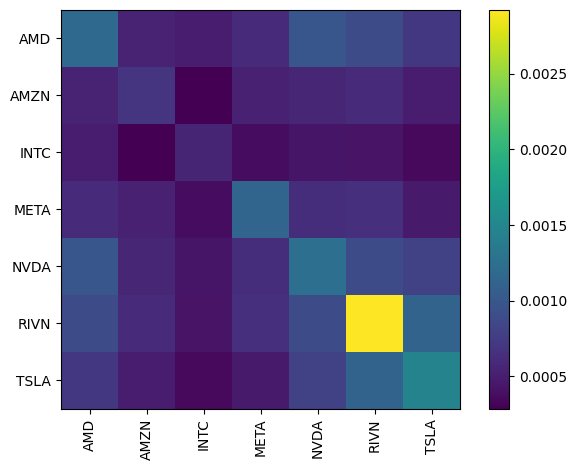

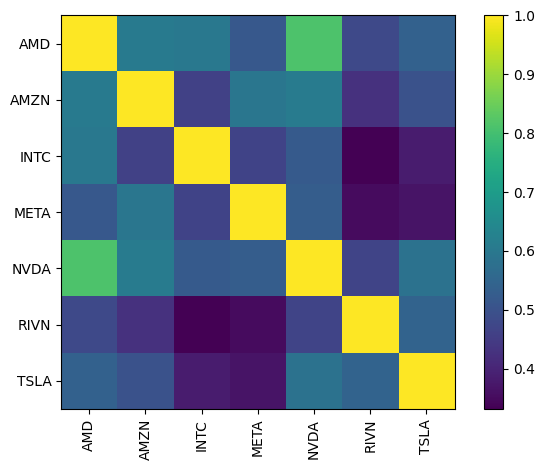

In [39]:
covariance_matrix = returns.cov()

covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [40]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

Using the previously defined function, market prices from the Vanguard S&P 500 index and market capitalisations for each ticker can be retrieved. These are used to calculate the 'Prior' and 'Delta'.

<li>Delta represents the risk-aversion co-efficient, and is used to scale the equilibrium returns. This determines the risk aversion of the investor.
<li>Prior is used to calculate the equilibrium returns based on the market portfolio (VOO). This is the benchmark portfolio which will be skewed once investor views are provided in the following section.

In [41]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

prior

[*********************100%***********************]  7 of 7 completed


Ticker
AMD     0.000438
AMZN    0.000075
INTC    0.000251
META    0.000444
NVDA    0.001084
RIVN   -0.000343
TSLA    0.000028
dtype: float64

### Calculate Sentiment Indicators (x5)
#### Calculate Relative Strength Index (RSI)

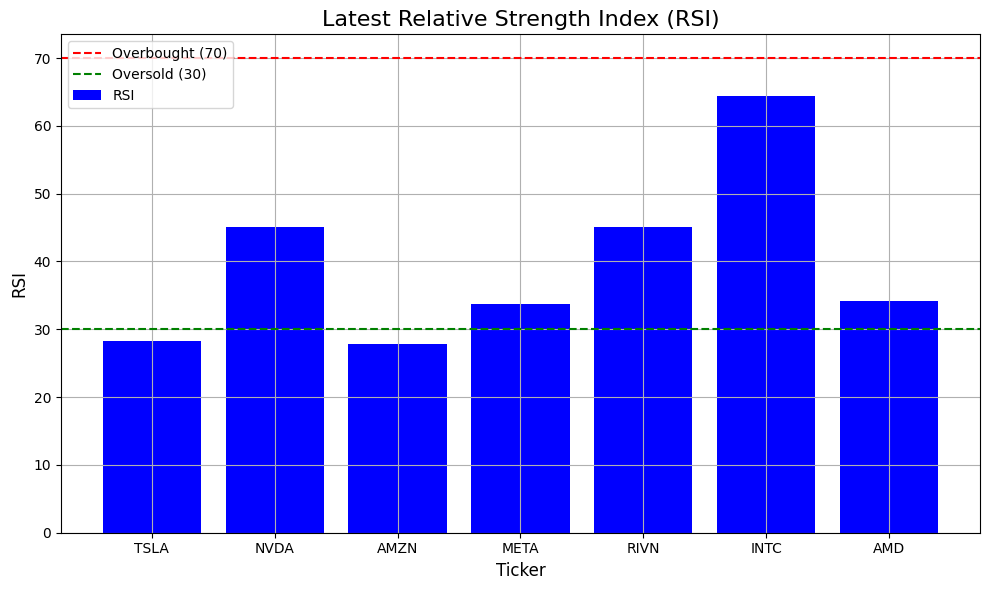

In [42]:
def calculate_stock_rsi(tickers, period=14):
    """
    Calculates the Relative Strength Index (RSI) values for a list of stocks. 
    Used as a momentum indicator to analyse recent overbought or oversold conditions 
    and the general trend (upward/downward) for a given stock.

    Parameters:
    tickers: list of str
        List of stock tickers.
    period: int
        Lookback period for RSI

    Returns:
    rsi_dict: dict
        Dictionary of tickers with their corresponding RSI value. Higher values indicate
        a stronger upward trend, versus lower values indicating a downtrend.
    """
    if not isinstance(tickers, list):
        print("tickers must be a list of strings")
        return None

    rsi_dict = {}
    for ticker in tickers:
        try:
            stock_data = yf.Ticker(ticker).history(period="1y")

            stock_data['Change'] = stock_data['Close'].diff()

            stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
            stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

            stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
            stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

            stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
            stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

            rsi_dict[ticker] = stock_data['RSI'].iloc[-1]
        
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating RSI")
            rsi_dict[ticker] = None

    return rsi_dict

def plot_stock_rsi(tickers, period=14):
    """
    Plots the Relative Strength Index (RSI) values for a list of stocks on a
    single bar chart. With a red dashed line indicating overbought, and a green
    dashed line indicating oversold conditions.

    Parameters:
    tickers: list of str
        List of stock tickers.
    period: int (defaults to 14 days)
        Lookback period for RSI
    """
    rsi_dict = calculate_stock_rsi(tickers, period)
    valid_rsi = {ticker: rsi for ticker, rsi in rsi_dict.items() if rsi is not None}

    if not valid_rsi:
        print("No valid RSI data available for plotting.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    tickers = list(valid_rsi.keys())
    rsi_values = list(valid_rsi.values())

    ax.bar(tickers, rsi_values, color='blue', label='RSI')
    ax.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax.set_title('Latest Relative Strength Index (RSI)', fontsize=16)
    ax.set_xlabel('Ticker', fontsize=12)
    ax.set_ylabel('RSI', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_stock_rsi(tickers)

In [43]:
rsi = calculate_stock_rsi(tickers)
rsi

{'TSLA': np.float64(28.344277078331075),
 'NVDA': np.float64(45.03030641180284),
 'AMZN': np.float64(27.85508435399113),
 'META': np.float64(33.797395224193394),
 'RIVN': np.float64(45.10703899040026),
 'INTC': np.float64(64.3878174820079),
 'AMD': np.float64(34.10405334401827)}

#### Stock Price Strength

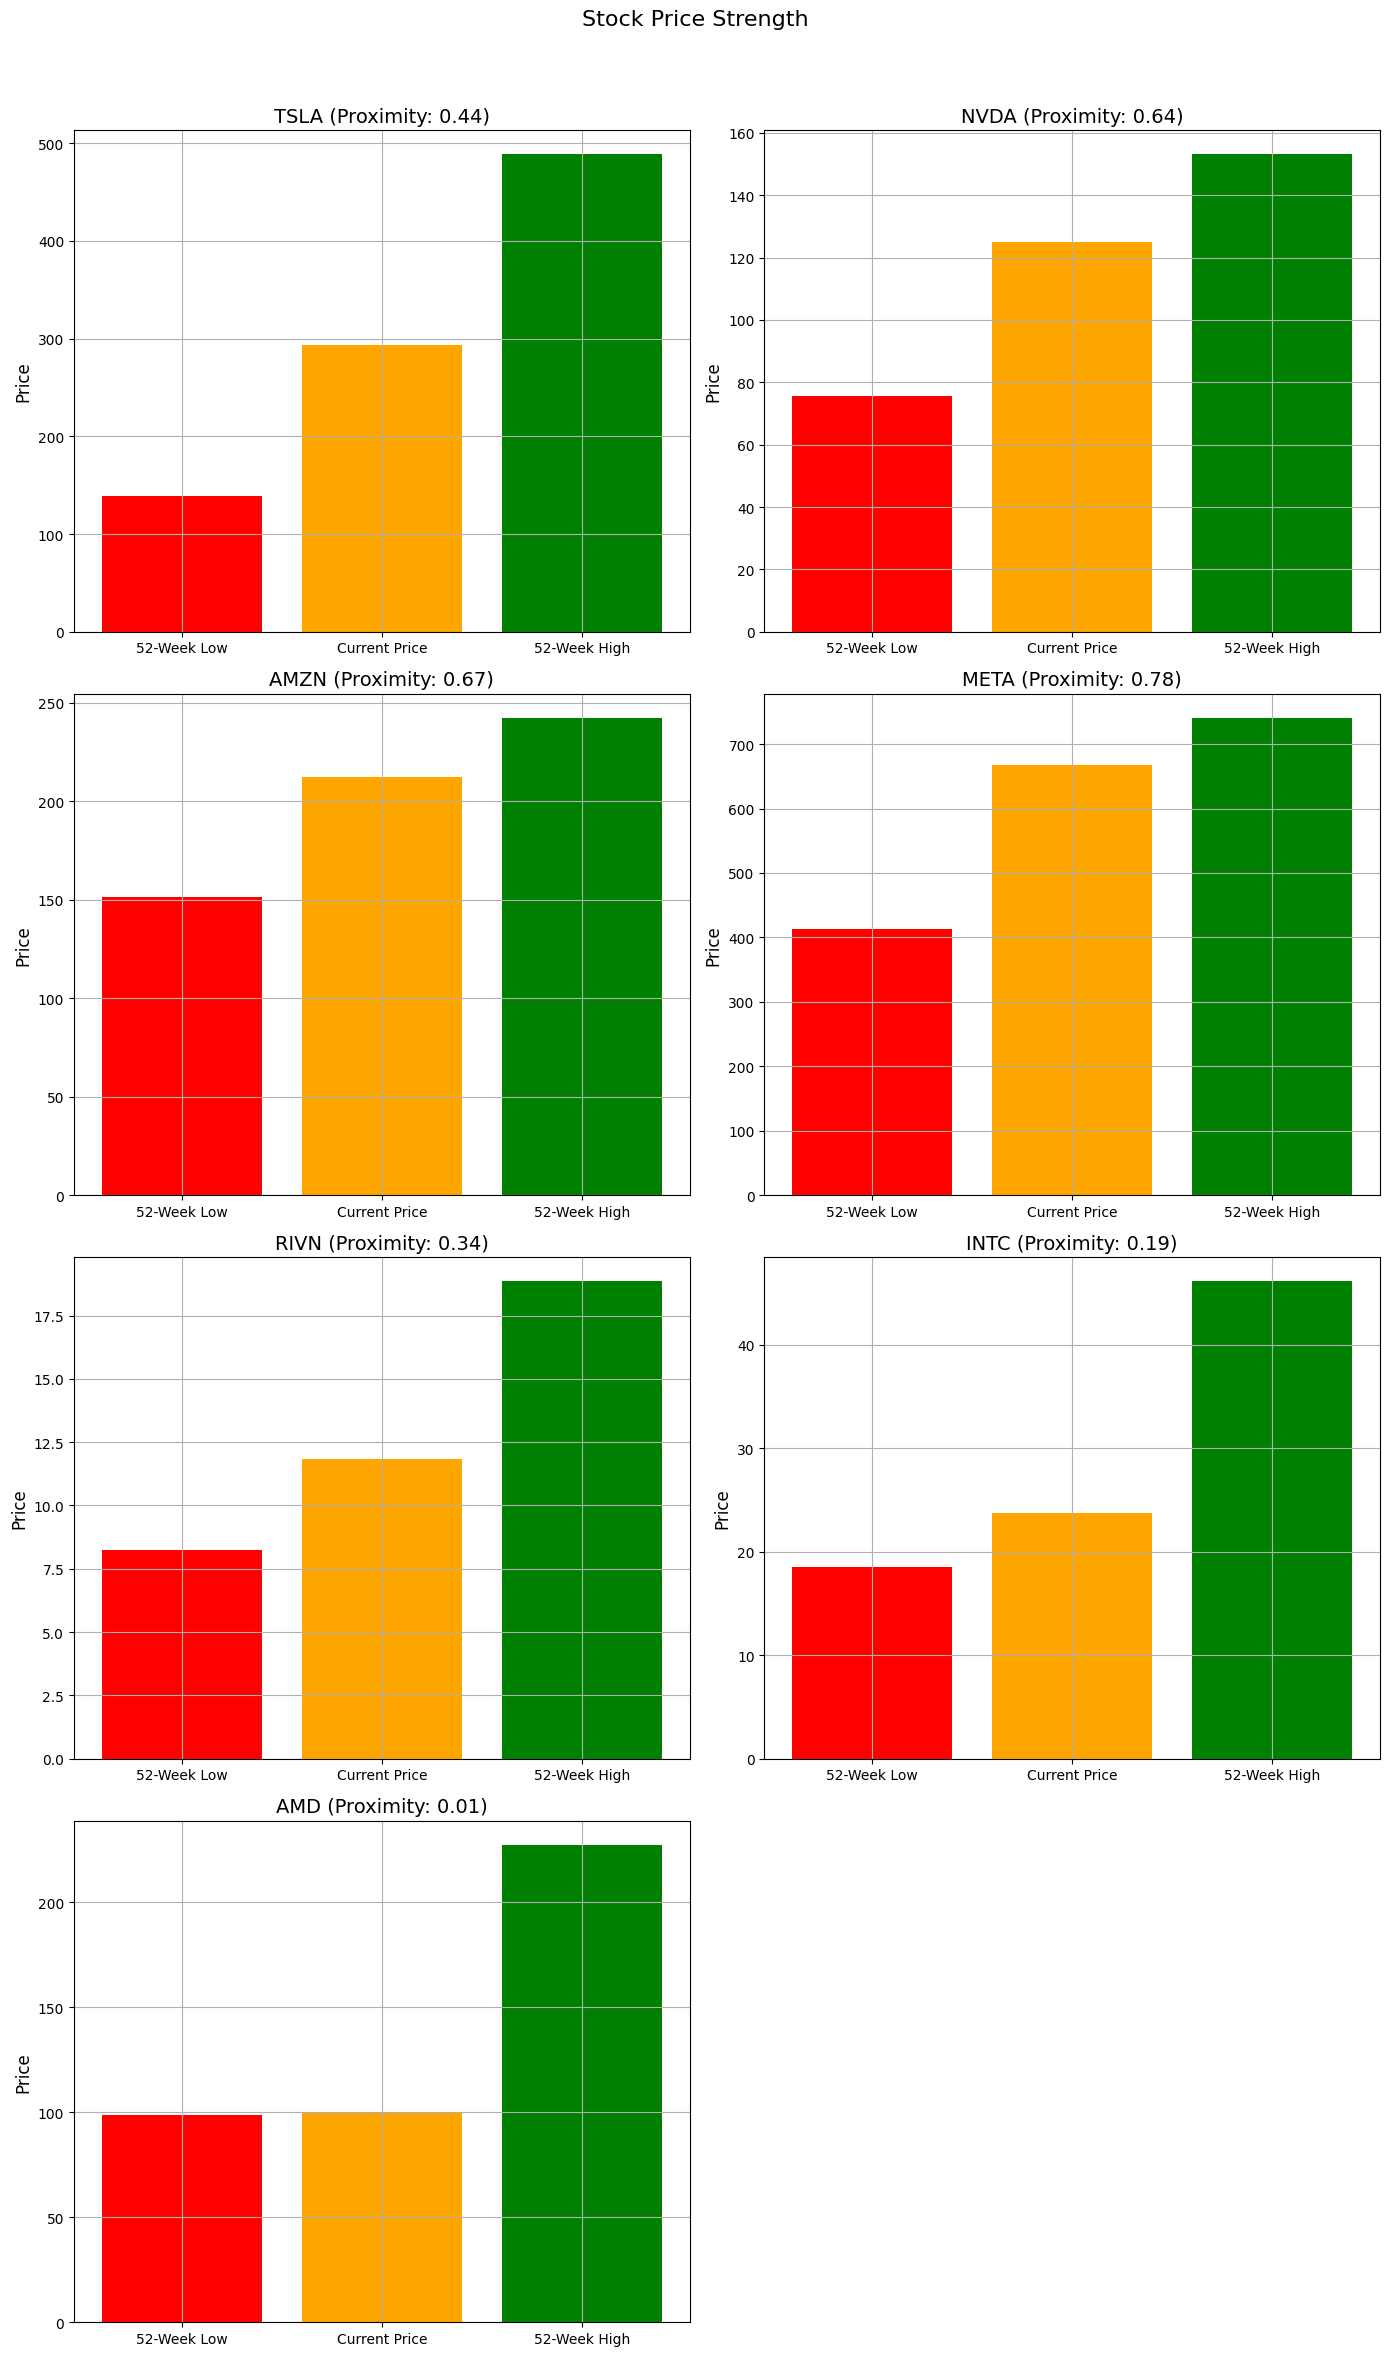

In [44]:
def calculate_stock_price_strength(tickers):
    """
    Calculates the Relative Price Strength, indicating whether the stock
    is currently outperforming the market (used as a benchmark) based on the
    price in proximity with its 52-week high.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    price_strength_dict: dict
        Tuple of tickers with their corresponding price strength value, including
        price strength, high, low, and current price or 'None' if the value is 0.
    """
    price_strength_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")

            high = stock_data['High'].max()
            low = stock_data['Low'].min()
            current_price = stock_data['Close'].iloc[-1]

            # Proximity to 52-week high
            price_strength = (current_price - low) / (high - low) if high - low != 0 else None

            price_strength_dict[ticker] = (price_strength, high, low, current_price)

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price strength")
            price_strength_dict[ticker] = None

    return price_strength_dict

def plot_stock_price_strength(tickers):
    """
    Plots the Stock Price Strength for each ticker on a bar chart subplot. Includes
    a heading of the ticker and it's proximity to the stock's 52-week high. Bar chart includes
    52-week low, 52-week high, and current price.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    price_strength_dict = calculate_stock_price_strength(tickers)

    nrows = (len(tickers) + 1) // 2
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows), sharex=False)
    fig.suptitle('Stock Price Strength', fontsize=16)
    axes = axes.flatten()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        data = price_strength_dict.get(ticker)

        if data is not None:
            price_strength, high, low, current_price = data
            ax.bar(['52-Week Low', 'Current Price', '52-Week High'], [low, current_price, high], color=['red', 'orange', 'green'])
            ax.set_title(f"{ticker} (Proximity: {price_strength:.2f})", fontsize=14)
            ax.set_ylabel('Price', fontsize=12)
            ax.grid(True)
        else:
            ax.set_title(f"{ticker} (Error)")
            ax.text(0.5, 0.5, "Error: Unable to fetch data", transform=ax.transAxes, fontsize=12, color="red", ha="center", va="center")
            ax.axis("off")

    # Remove surplus subplots
    for j in range(len(tickers), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stock_price_strength(tickers)

In [45]:
price_strengths = calculate_stock_price_strength(tickers)

for ticker, strength_tuple in price_strengths.items():
    print(f"{ticker}: {strength_tuple}")

TSLA: (np.float64(0.44084178393364803), np.float64(488.5400085449219), np.float64(138.8000030517578), np.float64(292.9800109863281))
NVDA: (np.float64(0.6361965185479468), np.float64(153.1300048828125), np.float64(75.58812265213056), np.float64(124.91999816894531))
AMZN: (np.float64(0.6673632793420745), np.float64(242.52000427246094), np.float64(151.61000061035156), np.float64(212.27999877929688))
META: (np.float64(0.7780181998297607), np.float64(740.9099731445312), np.float64(413.3607736978277), np.float64(668.2000122070312))
RIVN: (np.float64(0.33789524829828305), np.float64(18.854999542236328), np.float64(8.260000228881836), np.float64(11.84000015258789))
INTC: (np.float64(0.1888661415241652), np.float64(46.14861915352694), np.float64(18.510000228881836), np.float64(23.729999542236328))
AMD: (np.float64(0.009097256538315744), np.float64(227.3000030517578), np.float64(98.69000244140625), np.float64(99.86000061035156))


#### Stock Price Breadth

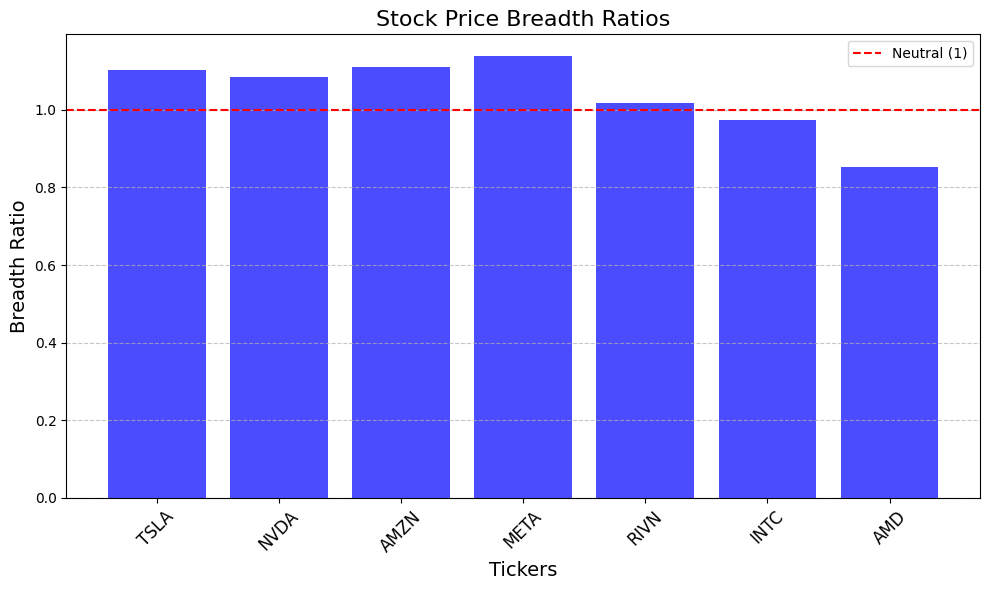

In [46]:
def calculate_stock_price_breadth(tickers):
    """
    Calculates the Stock Price Breadth which indicates the advancing
    versus declining stock price.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    breadth_ratios: dict
        Dictionary of tickers with their corresponding breadth ratio.
    """
    breadth_ratios = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker)
            prior_year_history = stock_data.history(period="1y")

            close_data = prior_year_history['Close'].tolist()
            volume_data = prior_year_history['Volume'].tolist()

            rising_vol = 0
            declining_vol = 0

            for i in range(1, len(close_data)):
                price_change = close_data[i] - close_data[i - 1]
                if price_change > 0:
                    rising_vol += volume_data[i]
                elif price_change < 0:
                    declining_vol += volume_data[i]

            if declining_vol == 0:
                breadth_ratio = float('inf') if rising_vol > 0 else 0
            else:
                breadth_ratio = rising_vol / declining_vol

            breadth_ratios[ticker] = breadth_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error}")
            breadth_ratios[ticker] = None

    return breadth_ratios

def plot_stock_price_breadth(tickers):
    """
    Plots the Stock Price Breadth for each ticker on a single bar chart.
    Includes a neutral line (red dashed) for reference.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    breadth_ratios = calculate_stock_price_breadth(tickers)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(breadth_ratios.keys(), breadth_ratios.values(), color="blue", alpha=0.7)

    ax.set_title("Stock Price Breadth Ratios", fontsize=16)
    ax.set_ylabel("Breadth Ratio", fontsize=14)
    ax.set_xlabel("Tickers", fontsize=14)
    ax.axhline(1, color="red", linestyle="--", label="Neutral (1)")  # neutral ref line
    ax.legend(loc="upper right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_stock_price_breadth(tickers)

In [47]:
breadth_ratios = calculate_stock_price_breadth(tickers)
breadth_ratios

{'TSLA': 1.1016039845591807,
 'NVDA': 1.0846621206529188,
 'AMZN': 1.1102108415061382,
 'META': 1.1377010306331077,
 'RIVN': 1.0186173515750867,
 'INTC': 0.9743106652901469,
 'AMD': 0.8516793356205505}

#### Market Volatility

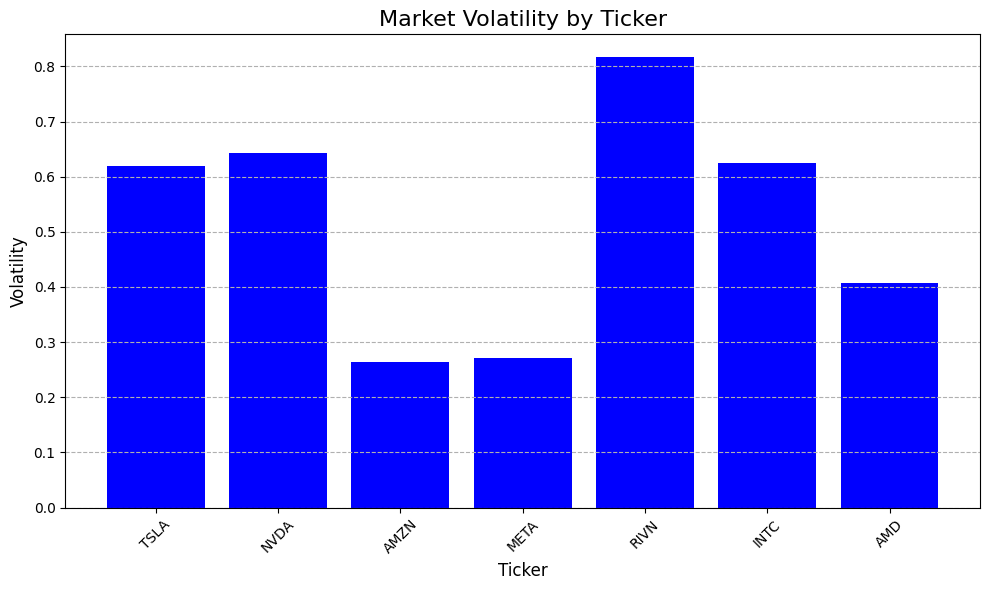

In [48]:
def calculate_market_volatility(tickers):
    volatility_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")
            stock_data['Returns'] = stock_data['Close'].pct_change()
            stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std() * np.sqrt(252)
            latest_volatility = stock_data['Volatility'].iloc[-1]
            volatility_dict[ticker] = latest_volatility

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating volatility")
            volatility_dict[ticker] = None

    return volatility_dict

def plot_market_volatility(tickers):
    """
    Plots the market volatility for each ticker on a single bar chart.
    Includes a neutral line (red dashed) for reference.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    volatility_dict = calculate_market_volatility(tickers)
    
    # get volatility values
    tickers_list = list(volatility_dict.keys())
    volatility_values = [volatility_dict[ticker] for ticker in tickers_list]

    plt.figure(figsize=(10, 6))
    plt.bar(tickers_list, volatility_values, color='blue')
    plt.title('Market Volatility by Ticker', fontsize=16)
    plt.xlabel('Ticker', fontsize=12)
    plt.ylabel('Volatility', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, axis="y", linestyle="--")
    plt.tight_layout()
    plt.show()

plot_market_volatility(tickers)

In [49]:
volatilty = calculate_market_volatility(tickers)
volatilty

{'TSLA': np.float64(0.6190803655254573),
 'NVDA': np.float64(0.6425711343498354),
 'AMZN': np.float64(0.26430232291236305),
 'META': np.float64(0.27050673258112345),
 'RIVN': np.float64(0.8172301317268225),
 'INTC': np.float64(0.6243318610094011),
 'AMD': np.float64(0.4068852452626624)}

#### Put-Call Ratio

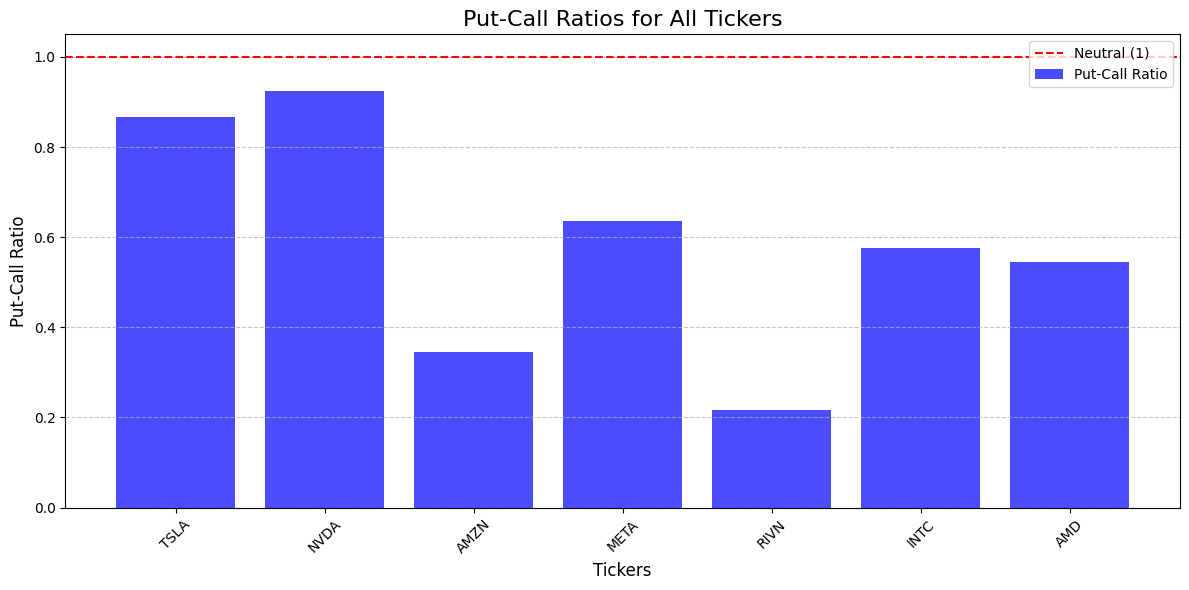

In [50]:
def calculate_put_call_ratio(tickers):
    """
    Calculates the put-call ratio for a given list of tickers
    based on the volume of options.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    put_call_dict: dict
        Dictionary of tickers with their corresponding put-call ratio, 
        calculated as the total put volume divided by total call volume.
        For any errors, this is set to 'None'.
    """
    put_call_dict = {}
    
    for ticker in tickers:
        try:
            # get options chain for ticker
            options = yf.Ticker(ticker).option_chain()
            puts = options.puts
            calls = options.calls

            # total volume
            total_put_volume = puts['volume'].sum()
            total_call_volume = calls['volume'].sum()

            # calculate ratio
            put_call_ratio = total_put_volume / total_call_volume if total_call_volume != 0 else None
            put_call_dict[ticker] = put_call_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating put-call ratio")
            put_call_dict[ticker] = None
    
    return put_call_dict

def plot_put_call_ratio(tickers):
    """
    Plots the put-call ratio for each ticker on a single bar chart, with
    a neutral reference point (set as 1) marked with a red dashed line.

    Parameters:
    tickers: list of str
        List of stock tickers.
    """
    put_call_dict = calculate_put_call_ratio(tickers)
    valid_data = [(ticker, ratio) for ticker, ratio in put_call_dict.items() if ratio is not None]
    tickers, ratios = zip(*valid_data) if valid_data else ([], [])

    plt.figure(figsize=(12, 6))
    plt.bar(tickers, ratios, color='blue', alpha=0.7, label='Put-Call Ratio')
    plt.axhline(1, color='red', linestyle='--', label='Neutral (1)')  # Neutral line at ratio = 1
    plt.title('Put-Call Ratios for All Tickers', fontsize=16)
    plt.xlabel('Tickers', fontsize=12)
    plt.ylabel('Put-Call Ratio', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_put_call_ratio(tickers)

In [51]:
pcr = calculate_put_call_ratio(tickers)
pcr

{'TSLA': np.float64(0.8669394431020292),
 'NVDA': np.float64(0.9249381310344026),
 'AMZN': np.float64(0.3446040723257348),
 'META': np.float64(0.6361440580766169),
 'RIVN': np.float64(0.21581712883059104),
 'INTC': np.float64(0.5752302834156632),
 'AMD': np.float64(0.5447658765770997)}

### Get Stock-Specific Fear-Greed Score

In [52]:
def get_fear_greed(tickers):
    """
    Calculates an overarching fear-greed score based on the individual
    stock sentiment indicators. First retrieves individual values, then
    normalises each value to the same scale. Sets the weight of each indicator,
    then times this by the respective normalised value.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    fear_greed_scores_dict: dict
        Dictionary of tickers with their corresponding amalgamated fear-greed score.
        For any errors, this is set to 'None'.
    """
    
    # Define overarching dictionary to store fear-greed scores
    fear_greed_scores_dict = {}

    # Call individual sentiment functions
    rsi_dict = calculate_stock_rsi(tickers)
    price_strength_dict = calculate_stock_price_strength(tickers)
    breadth_dict = calculate_stock_price_breadth(tickers)
    volatility_dict = calculate_market_volatility(tickers)
    put_call_ratio_dict = calculate_put_call_ratio(tickers)

    for ticker in tickers:
        try:
            # Get values from each indicator
            rsi = rsi_dict.get(ticker, None)
            price_strength_tuple = price_strength_dict.get(ticker, None)  # Get the whole tuple
            breadth_ratio = breadth_dict.get(ticker, None)
            volatility = volatility_dict.get(ticker, None)
            put_call_ratio = put_call_ratio_dict.get(ticker, None)

            # Get price_strength from tuple (price_strength, high, low, current_price)
            price_strength = price_strength_tuple[0] if price_strength_tuple else None

            # Normalise and validate each indicator to the same scale (0-1)
            normalised_rsi = float(rsi) / 100 if rsi is not None and isinstance(rsi, (int, float)) else 0.5
            normalised_price_strength = float(price_strength) if price_strength is not None and isinstance(price_strength, (int, float)) else 0.5
            normalised_breadth = min(max(float(breadth_ratio) / 2, 0), 1) if breadth_ratio is not None and isinstance(breadth_ratio, (int, float)) else 0.5
            normalised_volatility = min(max(float(volatility) / 100, 0), 1) if volatility is not None and isinstance(volatility, (int, float)) else 0.5
            normalised_put_call_ratio = min(max(float(put_call_ratio), 0), 1) if put_call_ratio is not None and isinstance(put_call_ratio, (int, float)) else 0.5

            print(f"Ticker: {ticker}, RSI: {normalised_rsi}, Strength: {normalised_price_strength}, Breadth: {normalised_breadth}, Volatility: {normalised_volatility}, Put-Call: {normalised_put_call_ratio}")

            # Equal weights for each indicator
            # Can be re-adjusted based on investor preference
            rsi_weight = 0.2
            price_strength_weight = 0.2
            breadth_weight = 0.2
            volatility_weight = 0.2
            put_call_ratio_weight = 0.2

            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight +
                normalised_volatility * volatility_weight +
                normalised_put_call_ratio * put_call_ratio_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when attempting to calculate the fear-greed score")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

fear_greed_scores_dict = get_fear_greed(tickers)

print(f"\nFear-Greed Scores:\n {fear_greed_scores_dict}\n")

Ticker: TSLA, RSI: 0.28344277078331076, Strength: 0.44084178393364803, Breadth: 0.5508019922795904, Volatility: 0.006190803655254573, Put-Call: 0.8669394431020292
Ticker: NVDA, RSI: 0.4503030641180284, Strength: 0.6361965185479468, Breadth: 0.5423310603264594, Volatility: 0.0064257113434983545, Put-Call: 0.9249381310344026
Ticker: AMZN, RSI: 0.27855084353991133, Strength: 0.6673632793420745, Breadth: 0.5551054207530691, Volatility: 0.0026430232291236306, Put-Call: 0.3446040723257348
Ticker: META, RSI: 0.33797395224193394, Strength: 0.7780181998297607, Breadth: 0.5688505153165538, Volatility: 0.002705067325811234, Put-Call: 0.6361440580766169
Ticker: RIVN, RSI: 0.4510703899040026, Strength: 0.33789524829828305, Breadth: 0.5093086757875434, Volatility: 0.008172301317268225, Put-Call: 0.21581712883059104
Ticker: INTC, RSI: 0.643878174820079, Strength: 0.1888661415241652, Breadth: 0.48715533264507344, Volatility: 0.006243318610094011, Put-Call: 0.5752302834156632
Ticker: AMD, RSI: 0.341040

In [53]:
total = sum(fear_greed_scores_dict.values())

normalized_values = {ticker: (value / total) for ticker, value in fear_greed_scores_dict.items()} # normalise to equate to 1
print(normalized_values)

fg_scores_df = pd.DataFrame.from_dict(normalized_values, orient='index', columns=['Normalised Fear-Greed Score'])
fg_scores_df

{'TSLA': 0.1576231081069844, 'NVDA': 0.1878515303091316, 'AMZN': 0.13561458653830274, 'META': 0.1704983983587311, 'RIVN': 0.11169447301930605, 'INTC': 0.13951122734348223, 'AMD': 0.0972066763240619}


,Normalised Fear-Greed Score
TSLA,0.157623
NVDA,0.187852
AMZN,0.135615
META,0.170498
RIVN,0.111694
INTC,0.139511
AMD,0.097207


### Run Black Litterman Model

View confidences are defined as a list, with each confidence corresponding to a given view. These are set as equal values, to allow room for a more nuanced method to be implemented in subsequent model variants.

In [54]:
confidences = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

fear_greed_bl = BlackLittermanModel(
    covariance_matrix,
    pi=prior,
    absolute_views=None,
    Q=fg_scores_df,
    P=None,
    omega=None,
    view_confidences=confidences,
    tau=0.025,
    risk_aversion=delta[0]
)

C:\Users\chana\AppData\Local\Temp\ipykernel_9368\4103820924.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_aversion=delta[0]


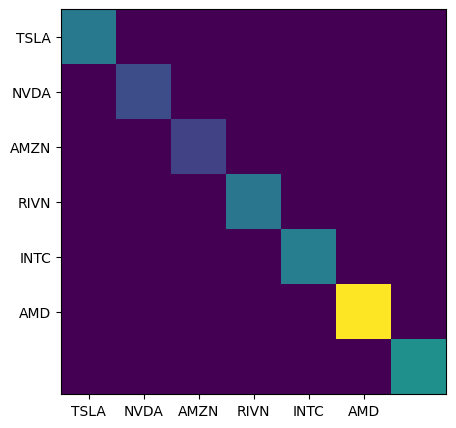

In [55]:
def plot_omega():
    """
    Plots the Black Litterman omega value (view uncertainties)
    for all tickers where a view has been defined.
    """

    # Only plot for tickers where views have been defined
    tickers_with_views = ["TSLA", "NVDA", "AMZN", "RIVN", "INTC", "AMD"]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(fear_greed_bl.omega)

    ax.set_xticks(np.arange(len(tickers_with_views)))
    ax.set_yticks(np.arange(len(tickers_with_views)))

    ax.set_xticklabels(tickers_with_views)
    ax.set_yticklabels(tickers_with_views)
    plt.show()

    np.diag(fear_greed_bl.omega)

plot_omega()

### Calculate Posterior Returns

Posterior returns are then calculated based on the Black Litterman model which produces a posterior estimate of the returns vector.

In [56]:
fear_greed_returns = fear_greed_bl.bl_returns()
fear_greed_returns

Ticker
AMD     0.131537
AMZN    0.117412
INTC    0.092397
META    0.130671
NVDA    0.124172
RIVN    0.131829
TSLA    0.101264
dtype: float64

The returns are difficult to visualise on their own, so these are added to a Pandas series alongside the Prior (market implied) and the views determined by the investor so the correlation between the values can be understood. 

In [57]:
views_series = pd.Series(normalized_values)

returns_df = pd.DataFrame([prior, fear_greed_returns, views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.000438,0.131537,0.097207
AMZN,0.000075,0.117412,0.135615
INTC,0.000251,0.092397,0.139511
META,0.000444,0.130671,0.170498
NVDA,0.001084,0.124172,0.187852
RIVN,-0.000343,0.131829,0.111694
TSLA,0.000028,0.101264,0.157623


<Axes: >

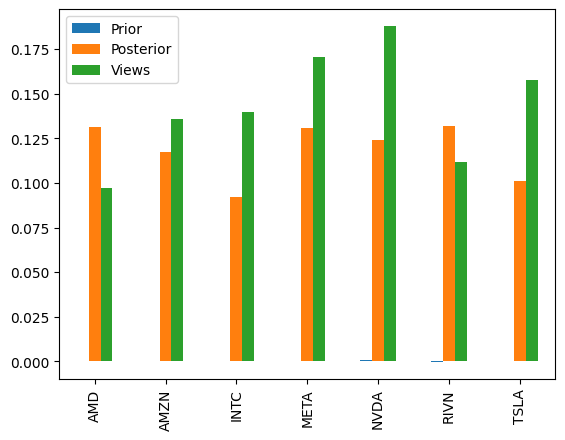

In [58]:
# For better understanding of the above series
# the correlation between the three values are plotted on a bar graph
returns_df.plot.bar()

<Axes: >

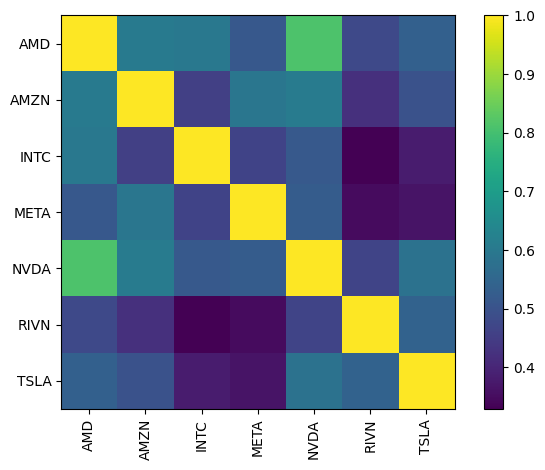

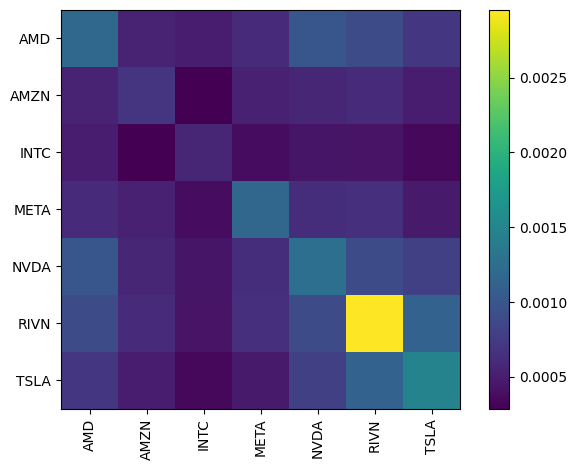

In [59]:
# Calculation of the new posterior covariance matrix
fg_posterior_cov = fear_greed_bl.bl_cov()

# Alongside the plotted matrices
# for the correlation and covariance visualisations
plotting.plot_covariance(fg_posterior_cov, plot_correlation=True)
plotting.plot_covariance(fg_posterior_cov, plot_correlation=False)

### Efficient Frontier Weights

The following section is used to generate the allocation weights based on the Black Litterman returns and posterior covariance matrix. The weights are optimised for both Minimum Variance and Max Sharpe portfolios, which can be used as per the investor's risk tolerance and personal strategy.

The allocations per optimised weights are visualised further down to give a better understanding of how each strategy allocates the given assets.

#### Minimum Volatility

In [60]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_1 = EfficientFrontier(fear_greed_returns, fg_posterior_cov)

# Retrieve the Max Sharpe portfolio weights
min_vol_weights = ef_1.min_volatility()

# Clean the weights to ensure they are rounded and sum to 1
cleaned_weights_min_vol = ef_1.clean_weights()

cleaned_weights_min_vol

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.3748),
             ('INTC', 0.57081),
             ('META', 0.01628),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.03811)])

#### Max Sharpe

In [61]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_2 = EfficientFrontier(fear_greed_returns, fg_posterior_cov)

# Retrieve the Max Sharpe portfolio weights
max_sharpe_weights = ef_2.max_sharpe()

# Clean the weights to ensure they are rounded and sum to 1
cleaned_weights_max_sharpe = ef_2.clean_weights()

cleaned_weights_max_sharpe

OrderedDict([('AMD', 0.06889),
             ('AMZN', 0.43675),
             ('INTC', 0.33699),
             ('META', 0.15121),
             ('NVDA', 0.0),
             ('RIVN', 0.00616),
             ('TSLA', 0.0)])

### Plot Asset Allocation Pies

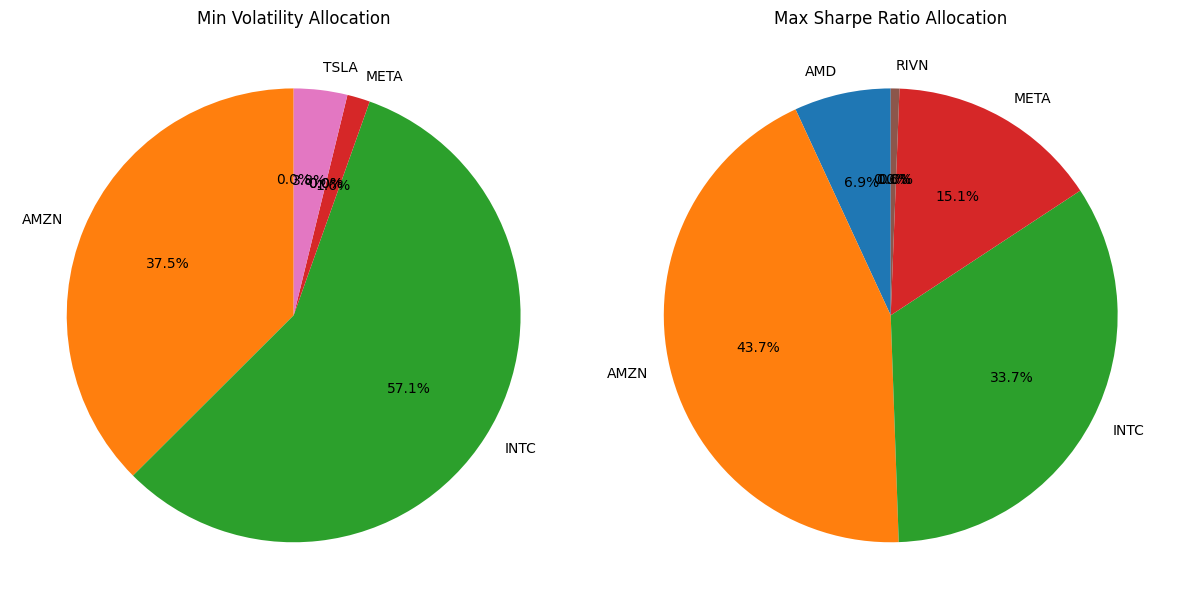

In [62]:
# Set the subplots for both pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Minimum Volaility allocation
pd.Series(cleaned_weights_min_vol).plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Min Volatility Allocation"
)

# Plot Max Sharpe allocation
pd.Series(cleaned_weights_max_sharpe).plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Max Sharpe Ratio Allocation"
)

plt.tight_layout()
plt.show()

### Portfolio Performance

The above allocations are effectively meaningless without an understanding of the annualised performance and risk-adjusted performance. The following section follows the same pattern of optimising for both Min Volatility portfolio and a Max Sharpe portfolio, and utilises the PyPortfolioOpt 'portfolio_performance' function to gauge the portfolio performance for each optimisation.

To breakdown the performance metrics:
- Expected annual return: The expected returns based on the given allocation
- Annual volatility: Used to gauge how risky the allocation is. A more diverse allocation can typically expect to have a lower volatility since the risk is distributed. For the default assets used in this notebook, since they are all in the tech sector, they are more likely to have a higher volatility.
- Sharpe ratio: Used to measure the returns per unit of risk. A higher ratio is better, where anything above 3 is typically considered very good.

#### Minimum Volatility Performance

In [63]:
ef_1.portfolio_performance(verbose=True)

Expected annual return: 10.3%
Annual volatility: 2.1%
Sharpe Ratio: 4.84


(np.float64(0.10273337882154972),
 np.float64(0.0212460886699505),
 np.float64(4.835401961154908))

#### Max Sharpe Performance

In [64]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: 11.2%
Annual volatility: 2.2%
Sharpe Ratio: 5.02


(np.float64(0.11204870379628772),
 np.float64(0.02230594123800336),
 np.float64(5.023267236326557))

### Get Discrete Alllocation (DA)

The discrete allocation is retrieved for both the Min Volatility and Max Sharpe portfolios based on a £10,000 portfolio. This allows you to determine the number of shares to buy for each stock, which is helpful to use for a loose translation for a real world portfolio. This is not to be confused with a continuous allocation, which instead allows the investor to purchase fractional (partial) shares.

#### Min Volatility DA

In [65]:
latest_prices = get_latest_prices(closing_prices)
da_min_vol = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_min_vol.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 2.16
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.380, desired 0.375
INTC: allocated 0.570, desired 0.571
META: allocated 0.000, desired 0.016
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.050, desired 0.038
Allocation has RMSE: 0.008
{'AMZN': 25, 'INTC': 115, 'TSLA': 2}


#### Max Sharpe DA

In [66]:
latest_prices = get_latest_prices(closing_prices)
da_max_sharpe = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_max_sharpe.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 4.02
AMD: allocated 0.074, desired 0.069
AMZN: allocated 0.441, desired 0.437
INTC: allocated 0.337, desired 0.337
META: allocated 0.141, desired 0.151
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.007, desired 0.006
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.005
{'AMD': 5, 'AMZN': 29, 'INTC': 68, 'META': 4, 'RIVN': 3}


## Sensitivity Analysis

To validate the robustness of each model variant, the input sensitivity of several parameters must be tested to ensure no anomoloies in the data are produced with varying input values.

The following parameters will be validated based on a reasonable range for each value, such that the variance of the model's output can be assessed: 

- Relative views (key parameter for each variant)
- View confidences (key parameter for each variant)
- Prior
- Tau - Currently set to 0.025 as per Idzorek's recommendation, however it would be interesting to see how this affects each model when increased/decreased.

#### Sensitivity to Tau (Uncertainty in Prior)

The first parameter to validate is the effect of tau on the portfolio i.e. what is the uncertainty of the prior? The range of values in tau_values intends to tilt the portfolio either towards the prior or the views based on the level of uncertainty.

C:\Users\chana\AppData\Local\Temp\ipykernel_9368\3973351617.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_aversion=delta[0]


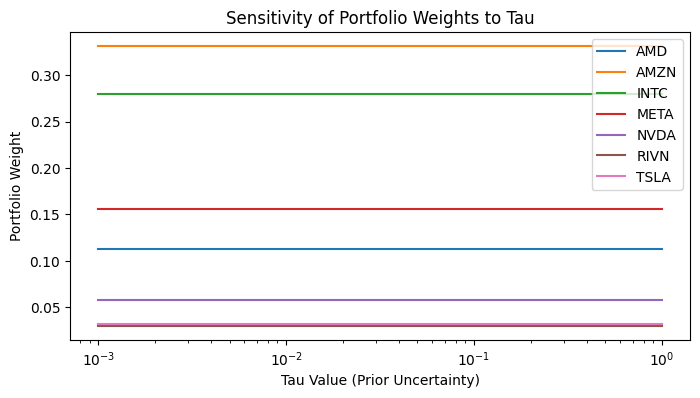

In [67]:
# Log scale from 0.001 to 1 for tau values
tau_values = np.logspace(-3, 0, 5)
results = []

for tau in tau_values:
    bl_model = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior, 
        absolute_views=None, 
        Q=fg_scores_df, 
        P=None, 
        omega="idzorek", 
        view_confidences=confidences, 
        tau=tau, # <-- Using the new Tau
        risk_aversion=delta[0]
    )
    posterior_weights = bl_model.bl_weights()
    results.append(posterior_weights)

posterior_weights_series = pd.Series(posterior_weights)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(posterior_weights_series.index):
    plt.plot(tau_values, [res[ticker] for res in results], label=ticker)

plt.xscale("log")
plt.xlabel("Tau Value (Prior Uncertainty)")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Tau")
plt.legend()
plt.show()

#### Sensitivity to Prior

C:\Users\chana\AppData\Local\Temp\ipykernel_9368\234355949.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_aversion=delta[0]


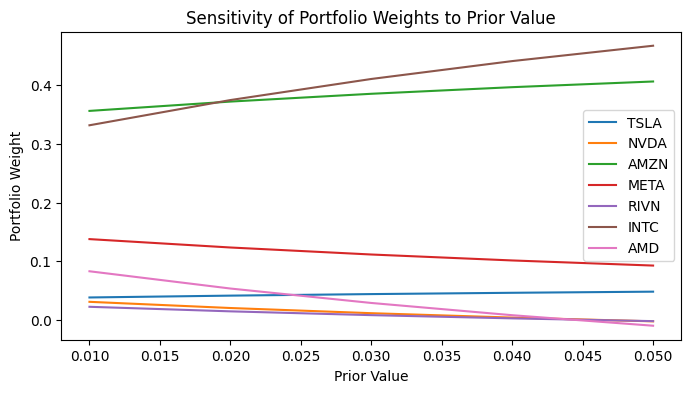

In [68]:
prior_values = np.linspace(0.01, 0.05, 5)
results_prior = []

for prior_value in prior_values:
    prior_test = pd.Series(prior_value, index=tickers)
    
    bl_model_prior = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior_test, # <-- Using the new Prior
        absolute_views=None, 
        Q=fg_scores_df, 
        P=None, 
        omega="idzorek", 
        view_confidences=confidences, 
        tau=tau, 
        risk_aversion=delta[0]
    )
    posterior_weights_prior = bl_model_prior.bl_weights()
    results_prior.append(posterior_weights_prior)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot(prior_values, [res[ticker] for res in results_prior], label=ticker)

plt.xlabel("Prior Value")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Prior Value")
plt.legend()
plt.show()

#### Sensitivity to Relative Views

C:\Users\chana\AppData\Local\Temp\ipykernel_9368\2107096240.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_aversion=delta[0]


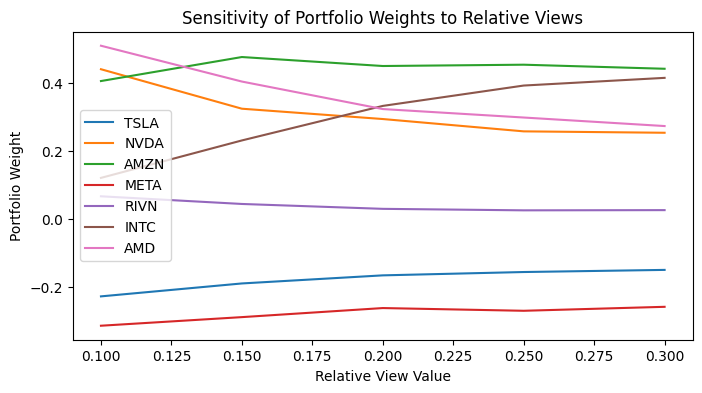

In [70]:
# Test sets of relative investor views
relative_views_range = [
    np.array([0.10, 0.05, 0.02, -0.03, 0.08, 0.05, -0.02]).reshape(-1, 1),
    np.array([0.15, 0.10, 0.05, -0.05, 0.12, 0.07, -0.03]).reshape(-1, 1),
    np.array([0.20, 0.15, 0.10, -0.07, 0.18, 0.09, -0.04]).reshape(-1, 1),
    np.array([0.25, 0.20, 0.15, -0.10, 0.22, 0.11, -0.05]).reshape(-1, 1),
    np.array([0.30, 0.25, 0.20, -0.12, 0.28, 0.14, -0.06]).reshape(-1, 1)
]
results_views = []

for views in relative_views_range:
    bl_model_views = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior, 
        absolute_views=None, 
        Q=views, # <-- Using the test set of investor views
        P=None, 
        omega="idzorek", 
        view_confidences=confidences, 
        tau=tau, 
        risk_aversion=delta[0]
    )
    posterior_weights_views = bl_model_views.bl_weights()
    results_views.append(posterior_weights_views)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot([views[0][0] for views in relative_views_range], [res[ticker] for res in results_views], label=ticker)

plt.xlabel("Relative View Value")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Relative Views")
plt.legend()
plt.show()

#### Sensitivity to View Confidence Levels

C:\Users\chana\AppData\Local\Temp\ipykernel_9368\2956455022.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_aversion=delta[0]


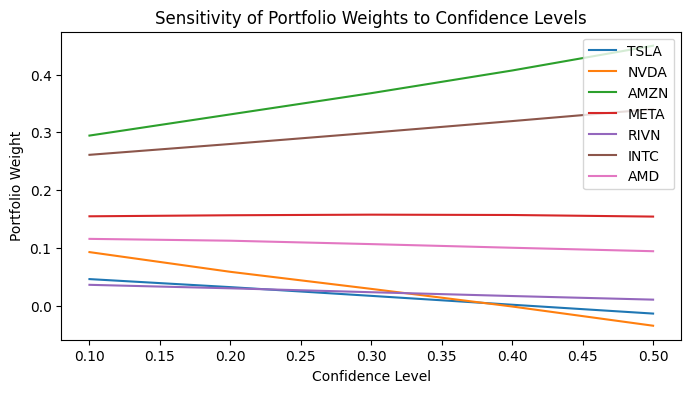

In [71]:
# Sets of view confidence levels
view_confidences = [
    np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
    np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]),
    np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]),
    np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]),
    np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
]

results_confidence_levels = []

for test_confidences in view_confidences:
    bl_model_views = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior, 
        absolute_views=None, 
        Q=fg_scores_df,
        P=None, 
        omega="idzorek", 
        view_confidences=test_confidences, # <-- Using the test set of view confidences levels
        tau=tau,
        risk_aversion=delta[0]
    )
    posterior_weights_views = bl_model_views.bl_weights()
    results_confidence_levels.append(posterior_weights_views)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot([conf[0] for conf in view_confidences], [res[ticker] for res in results_confidence_levels], label=ticker)

plt.xlabel("Confidence Level")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Confidence Levels")
plt.legend()
plt.show()